Copyright 2022 Fahmi Noor Fiqri

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [1]:
import os
import sys
sys.path.append(os.path.abspath('..'))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearnex import patch_sklearn
patch_sklearn()

from sklearn.preprocessing import StandardScaler

import tensorflow as tf

from experiments.helpers import plot_all, print_metrics, plot_loss

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Data Loading and Feature Engineering

In [2]:
df_train = pd.read_csv('../dataset/house_price_train.csv', parse_dates=["Time"])
df_test = pd.read_csv('../dataset/house_price_test.csv', parse_dates=["Time"])

In [3]:
cat_columns = ["City", "District", "Street", "Community", "Floor"] # ["City", "Floor"]
num_columns = ["#Floors", "#Rooms", "#Halls", "Area"]

In [4]:
# drop unused columns
df_train_pool = df_train.drop(columns=["Id", "Time", "Orient", "Lat", "Lon"])
df_test_pool = df_train.drop(columns=["Id", "Time", "Orient", "Lat", "Lon"])

In [5]:
# standardize price
scaler = StandardScaler()
scaler.fit(df_train_pool["Price"].values.reshape(-1, 1))

y_train = scaler.transform(df_train_pool["Price"].values.reshape(-1, 1))
y_test = scaler.transform(df_test_pool["Price"].values.reshape(-1, 1))

In [6]:
X_train_num = df_train_pool[num_columns].values
X_test_num = df_test_pool[num_columns].values

### Deep Learning based model using TensorFlow

In [7]:
# baseline model
tf.random.set_seed(42)

model_inputs = []
models_intermediate = []

# create categorical embedding model
categorical_models = []
for col in cat_columns:
    vocab = list(df_train_pool[col].unique())
    vocab_size = np.minimum(1000, df_train_pool[col].nunique() + 1)
    print(f"{col} vocab size: {vocab_size}")

    cat_input = tf.keras.layers.Input(shape=(1,), name=f"cat_{col}", dtype=tf.string)
    cat_lookup = tf.keras.layers.StringLookup(vocabulary=vocab, mask_token=None, num_oov_indices=0)(cat_input)
    cat_embedding = tf.keras.layers.Embedding(vocab_size, 200)(cat_lookup)
    cat_flatten = tf.keras.layers.Flatten()(cat_embedding)
    
    model_inputs.append(cat_input)
    categorical_models.append(cat_flatten)

# create numerical input
num_normalizer = tf.keras.layers.Normalization()
num_normalizer.adapt(X_train_num)

numerical_input = tf.keras.layers.Input(shape=(4,), name="num_input")
numerical_normalize_layer = num_normalizer(numerical_input)

model_inputs.append(numerical_input)

# merge all inputs
cat_num_concat = tf.keras.layers.concatenate([*categorical_models, numerical_normalize_layer])

# create hidden layers
dense1_layer = tf.keras.layers.Dense(256, activation="relu")(cat_num_concat)
dense2_layer = tf.keras.layers.Dense(128, activation="relu")(dense1_layer)
dense3_layer = tf.keras.layers.Dense(64, activation="relu")(dense2_layer)

# create output layer
output_layer = tf.keras.layers.Dense(1)(dense3_layer)

# create final model
baseline_model = tf.keras.Model(inputs=model_inputs, outputs=output_layer)

City vocab size: 35


2022-11-02 17:20:27.678433: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-02 17:20:27.714969: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-02 17:20:27.715359: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-02 17:20:27.716594: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow wi

District vocab size: 314
Street vocab size: 1000
Community vocab size: 1000
Floor vocab size: 8


2022-11-02 17:20:29.297196: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [8]:
baseline_model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanAbsoluteError()])

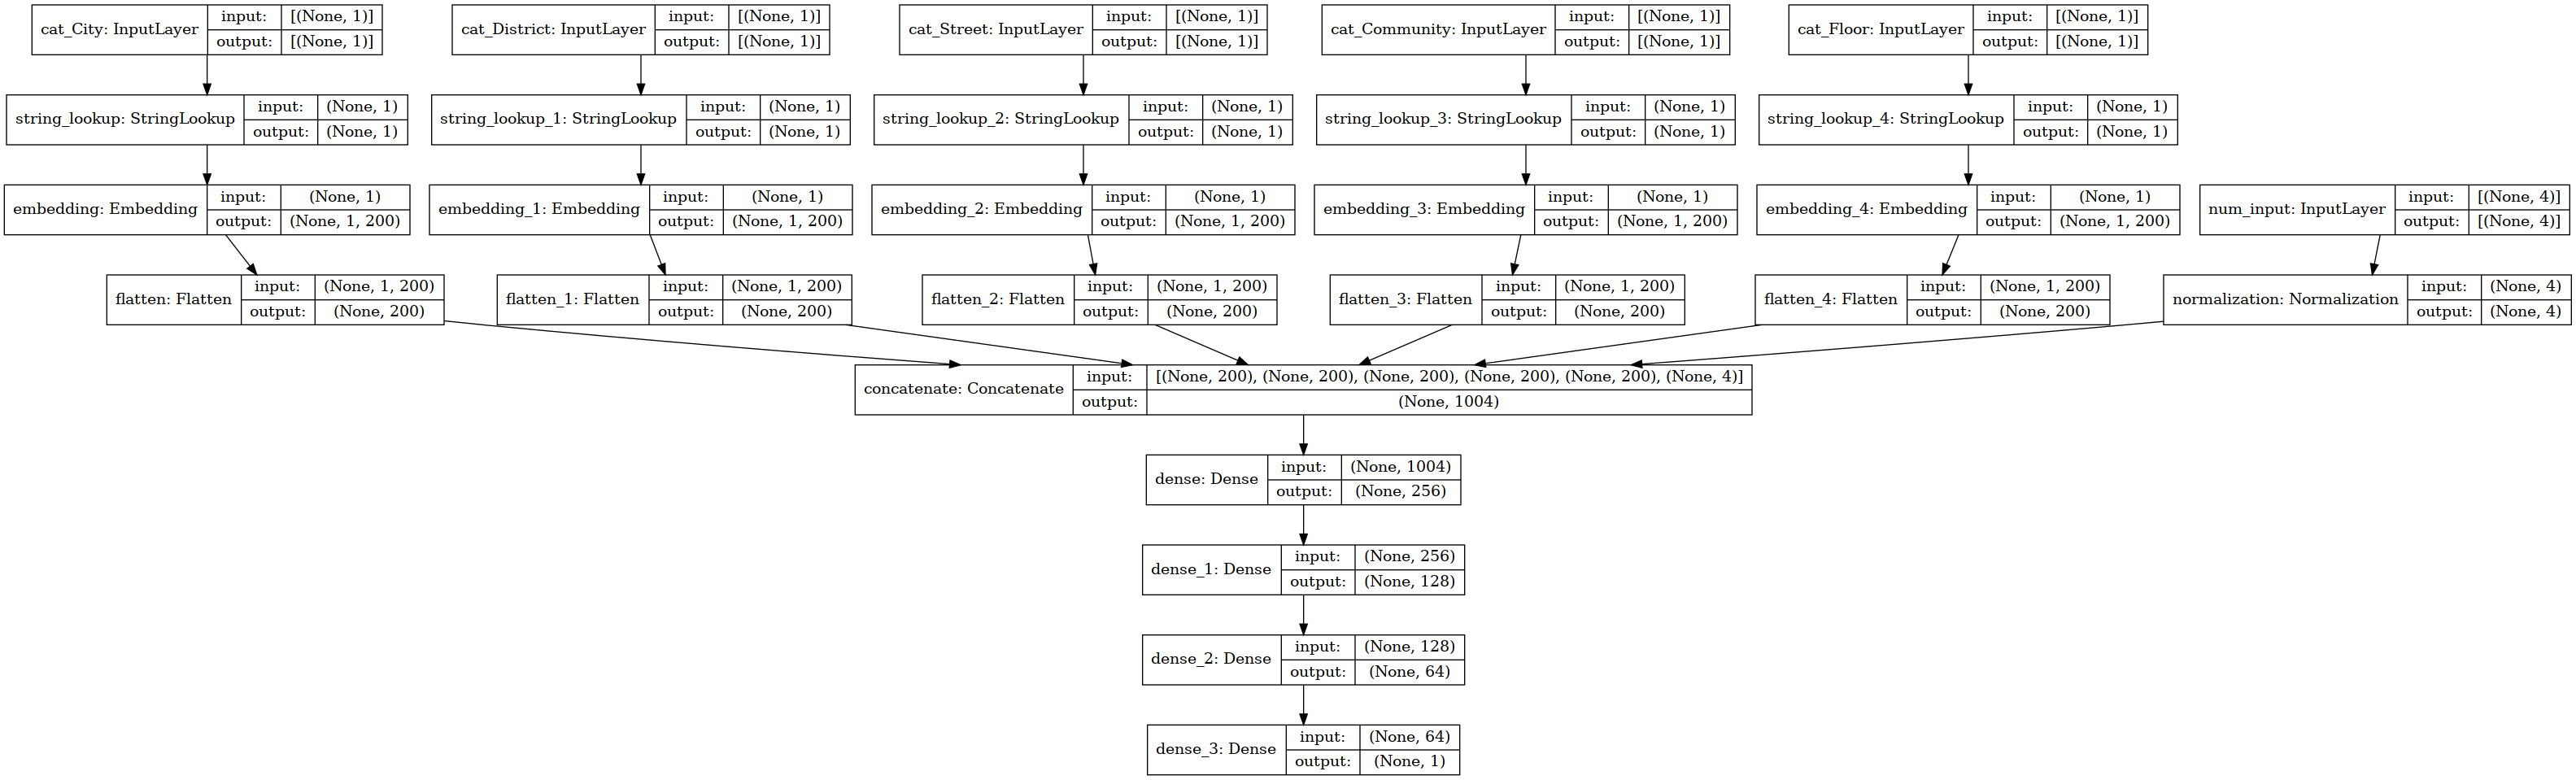

In [9]:
tf.keras.utils.plot_model(baseline_model, show_shapes=True)

In [10]:
baseline_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cat_City (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
cat_District (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
cat_Street (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
cat_Community (InputLayer)      [(None, 1)]          0                                            
______________________________________________________________________________________________

In [11]:
log_dir = "logs/fit/baseline_dense_akhir"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

train_inputs = {"num_input": X_train_num}
for col in cat_columns:
    train_inputs[f"cat_{col}"] = df_train_pool[col].values.reshape(-1, 1)

history = baseline_model.fit(train_inputs, y_train, validation_split=0.15, epochs=20, callbacks=[tensorboard_callback])

2022-11-02 17:20:48.435629: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-11-02 17:20:48.435677: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-11-02 17:20:48.435781: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2022-11-02 17:20:48.436173: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory
2022-11-02 17:20:48.446362: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1666] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2022-11-02 17:20:48.446530: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Epoch 1/20
    3/14692 [..............................] - ETA: 13:22 - loss: 0.7573 - mean_absolute_error: 0.6875

2022-11-02 17:20:50.817314: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-11-02 17:20:50.861747: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-11-02 17:20:50.861787: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-11-02 17:20:50.866770: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1666] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2022-11-02 17:20:50.907017: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-11-02 17:20:50.909534: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-11-02 17:20:50.910303: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler sessi

14692/14692 [==============================] - 557s 38ms/step - loss: 0.3009 - mean_absolute_error: 0.2686 - val_loss: 0.3187 - val_mean_absolute_error: 0.4307
Epoch 2/20
14692/14692 [==============================] - 551s 38ms/step - loss: 0.2858 - mean_absolute_error: 0.2568 - val_loss: 0.3004 - val_mean_absolute_error: 0.4053
Epoch 3/20
14692/14692 [==============================] - 551s 37ms/step - loss: 0.2812 - mean_absolute_error: 0.2535 - val_loss: 0.2709 - val_mean_absolute_error: 0.3821
Epoch 4/20
14692/14692 [==============================] - 551s 37ms/step - loss: 0.2785 - mean_absolute_error: 0.2515 - val_loss: 0.3167 - val_mean_absolute_error: 0.4138
Epoch 5/20
14692/14692 [==============================] - 551s 38ms/step - loss: 0.2757 - mean_absolute_error: 0.2499 - val_loss: 0.2585 - val_mean_absolute_error: 0.3709
Epoch 6/20
14692/14692 [==============================] - 552s 38ms/step - loss: 0.2727 - mean_absolute_error: 0.2491 - val_loss: 0.3138 - val_mean_absolute

## Evaluation

In [15]:
baseline_model.save("models/dnn")

2022-11-02 20:34:39.930704: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/dnn/assets


INFO:tensorflow:Assets written to: models/dnn/assets


In [12]:
test_inputs = {"num_input": X_test_num}
for col in cat_columns:
    test_inputs[f"cat_{col}"] = df_test_pool[col].values.reshape(-1, 1)

predicted = baseline_model.predict(test_inputs)
predicted_unscaled = scaler.inverse_transform(predicted.reshape(-1, 1))
y_true_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))

print_metrics(y_true_unscaled, predicted_unscaled)

Min:  -14621.198
Max:  2206551.2
R2:  0.765242073107379
MAPE:  0.22442468379898975
Log MAE:  nan


/home/fahmi/lomba/ieee-cyberc/experiments/helpers.py:10: RuntimeWarning: invalid value encountered in log
  return np.mean(np.abs(np.log(y_true) - np.log(y_pred)))


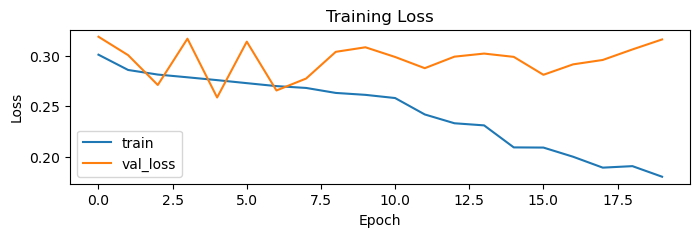

In [20]:
plot_loss(history)
plt.show()

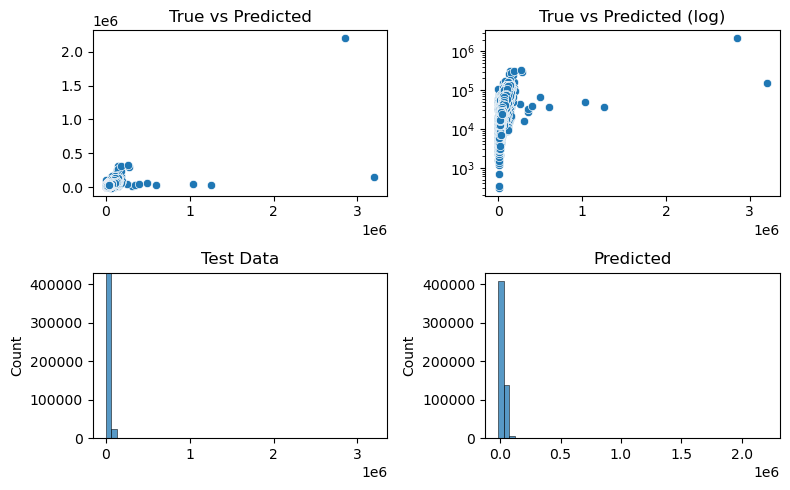

In [14]:
plot_all(y_true_unscaled, predicted_unscaled)
plt.show()